In [1]:
# Installation of dependencies
# %pip install gymnasium networkx pygraphviz numpy pandas matplotlib seaborn stable-baselines3 json5


**Importing Dependencies**

In [2]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v6 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [3]:
# Configuration of the network
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [4]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


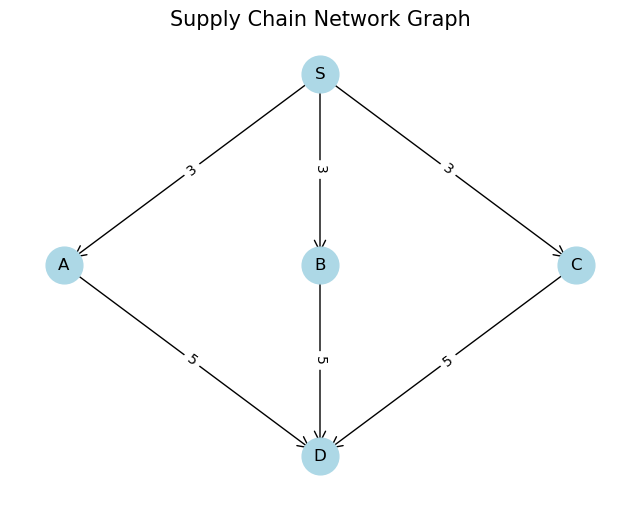

In [5]:
env.render_network()

In [6]:
env.state.shape

(93,)

In [7]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

**Testng the environment**

In [8]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        env.render()

# 30, 28, 32

Episode Length: 1
Stock Level: [[30. 28. 32.]]
Planned Demand: [0. 0. 0.]
Actual Demand: [0. 0. 0.]
Action: [50, 15, 15]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 50], maxlen=3),
    'B': deque([0, 0, 15], maxlen=3),
    'C': deque([0, 0, 15], maxlen=3)}

Episode Length: 2
Stock Level: [[21. 28. 32.]]
Planned Demand: [9. 0. 0.]
Actual Demand: [9. 0. 0.]
Action: [15, 50, 50]
Order: [0 0 0]
Reward: -68.0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 50, 15], maxlen=3),
    'B': deque([0, 15, 50], maxlen=3),
    'C': deque([0, 15, 50], maxlen=3)}

Episode Length: 3
Stock Level: [[13. 16. 15.]]
Planned Demand: [11. 14. 11.]
Actual Demand: [ 8. 12. 17.]
Action: [0, 50, 50]
Order: [0 0 0]
Reward: 113.0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([50, 15, 0], maxlen=3),
    'B': deque([15, 50, 50], maxlen=3),
    'C': deque([15, 5

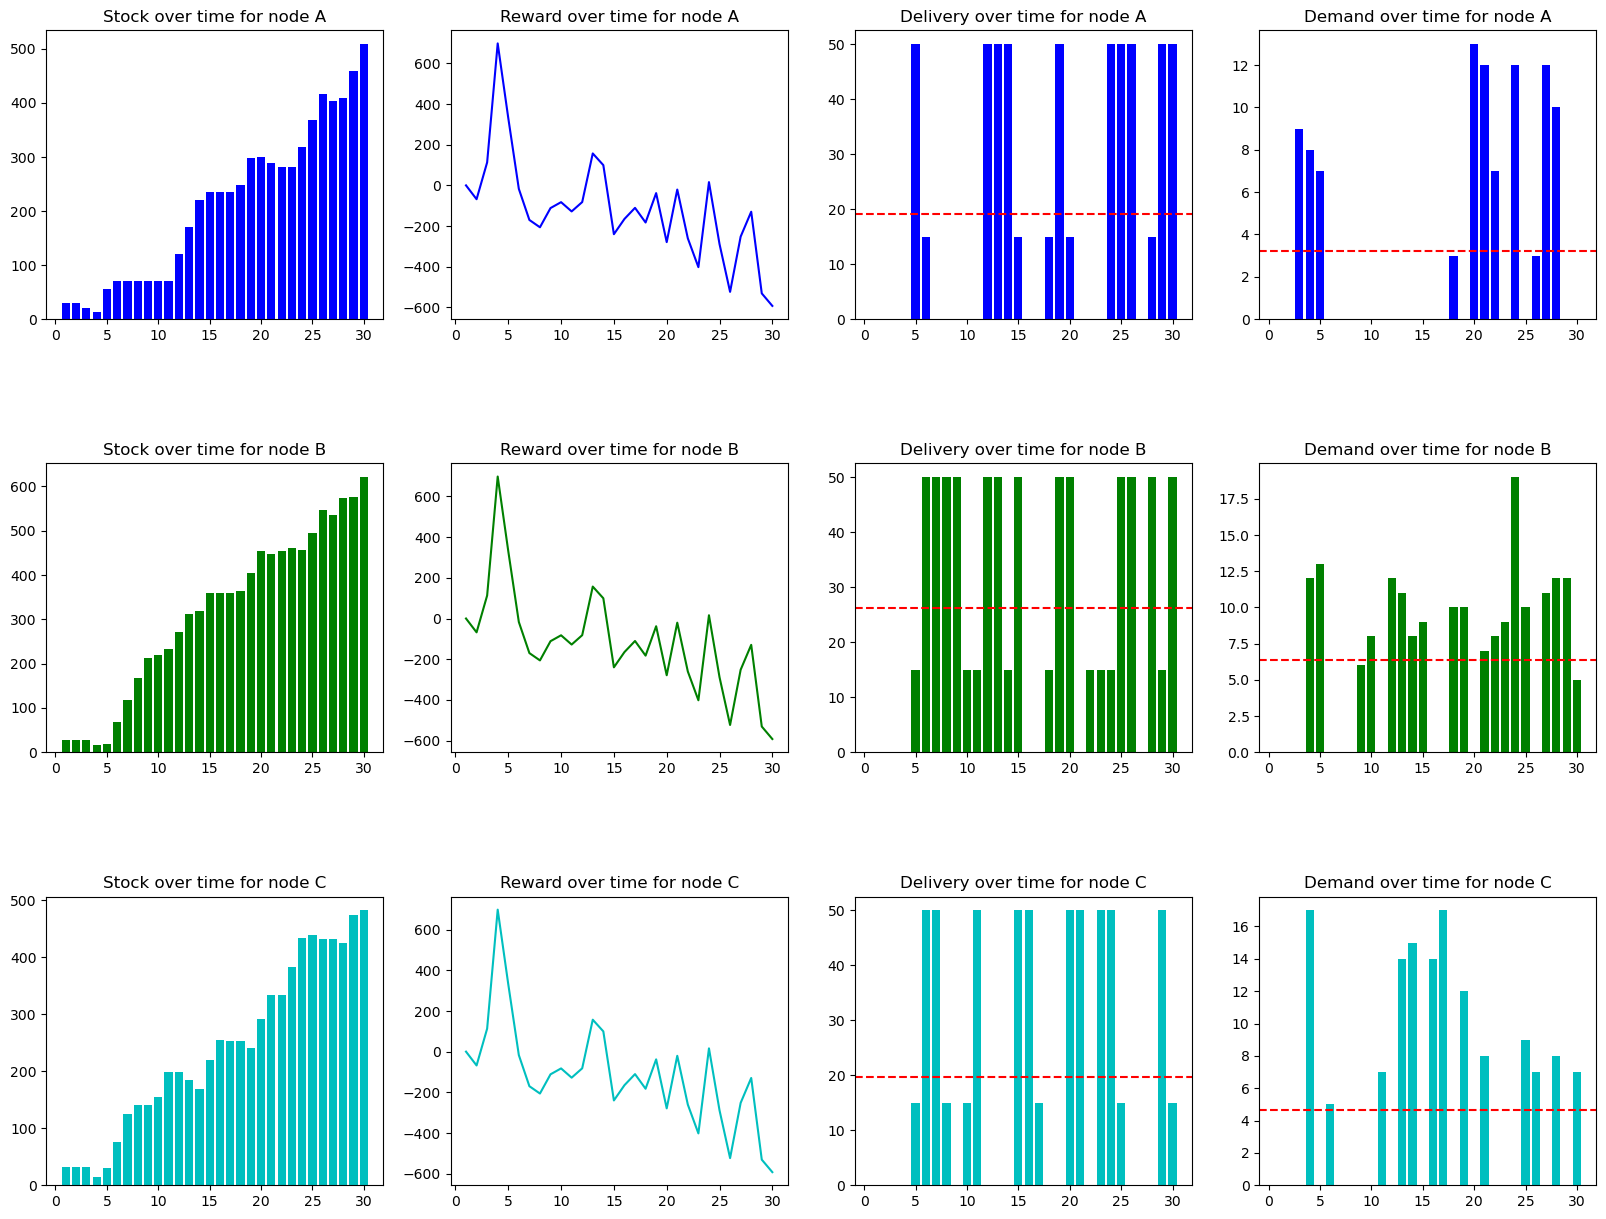

In [9]:
df = pd.read_csv('./Data/2024-10-19_15_last_environment_data.csv')
plot_data(df)

**Train Model**


In [16]:
log_path = os.path.join('Training', 'Logs')
# model_path = os.path.join('Training', 'Models', 'PPO')
model_path = os.path.join('Training', 'Models', 'A2C')

In [17]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

def make_env():
    # Create a new environment here
    env = SS_Mngmt_Env(network_config=network_config, EP_LENGTH=EP_LENGTH, render_mode="human")
    return env

num_envs = 8

dummy_env = DummyVecEnv([lambda: env])
vec_env = make_vec_env(make_env, n_envs=num_envs)

# model = PPO("MlpPolicy", 
#             dummy_env,
#             learning_rate = 0.0007,
#             gamma = 0.99,
#             verbose=1,
#             tensorboard_log=log_path)

model = A2C("MlpPolicy",
            vec_env,
            learning_rate = 0.0005,
            gamma = 0.99,
            verbose=1,
            tensorboard_log=log_path)

Using cpu device


In [18]:
model.learn(total_timesteps=100000)

Logging to Training/Logs/A2C_11
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 30        |
|    ep_rew_mean        | -3.59e+03 |
| time/                 |           |
|    fps                | 7844      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 4000      |
| train/                |           |
|    entropy_loss       | -3.26     |
|    explained_variance | -0.00173  |
|    learning_rate      | 0.0005    |
|    n_updates          | 99        |
|    policy_loss        | -1.01e+03 |
|    value_loss         | 3e+05     |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 30        |
|    ep_rew_mean        | -4.23e+03 |
| time/                 |           |
|    fps                | 8058      |
|    iterations         | 200       |
|    time_elapsed       | 0         |
|    total_timeste

In [19]:
model.save(model_path)
model.load(model_path)

# evaluate_policy(model, vec_env, n_eval_episodes=10, render=True, return_episode_rewards=True)
evaluate_policy(model, dummy_env, n_eval_episodes=1, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [[25. 22. 16.]]
Planned Demand: [ 5.  7. 18.]
Actual Demand: [ 5.  6. 16.]
Action: [15, 15, 15]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 15], maxlen=3),
    'C': deque([0, 0, 15], maxlen=3)}

Episode Length: 2
Stock Level: [[15. 22. 16.]]
Planned Demand: [8. 0. 0.]
Actual Demand: [10.  0.  0.]
Action: [15, 15, 15]
Order: [0 0 0]
Reward: 489.0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 15, 15], maxlen=3),
    'B': deque([0, 15, 15], maxlen=3),
    'C': deque([0, 15, 15], maxlen=3)}

Episode Length: 3
Stock Level: [[15. 10.  8.]]
Planned Demand: [ 0. 15. 10.]
Actual Demand: [ 0. 12.  8.]
Action: [15, 15, 15]
Order: [0 0 0]
Reward: 154.0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([15, 15, 15], maxlen=3),
    'B': deque([15, 15, 15], maxlen=3),
    'C': d

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


([741.0], [30])

In [20]:
file = './Data/2024-10-19_15_last_environment_data.csv'
df = pd.read_csv(file)

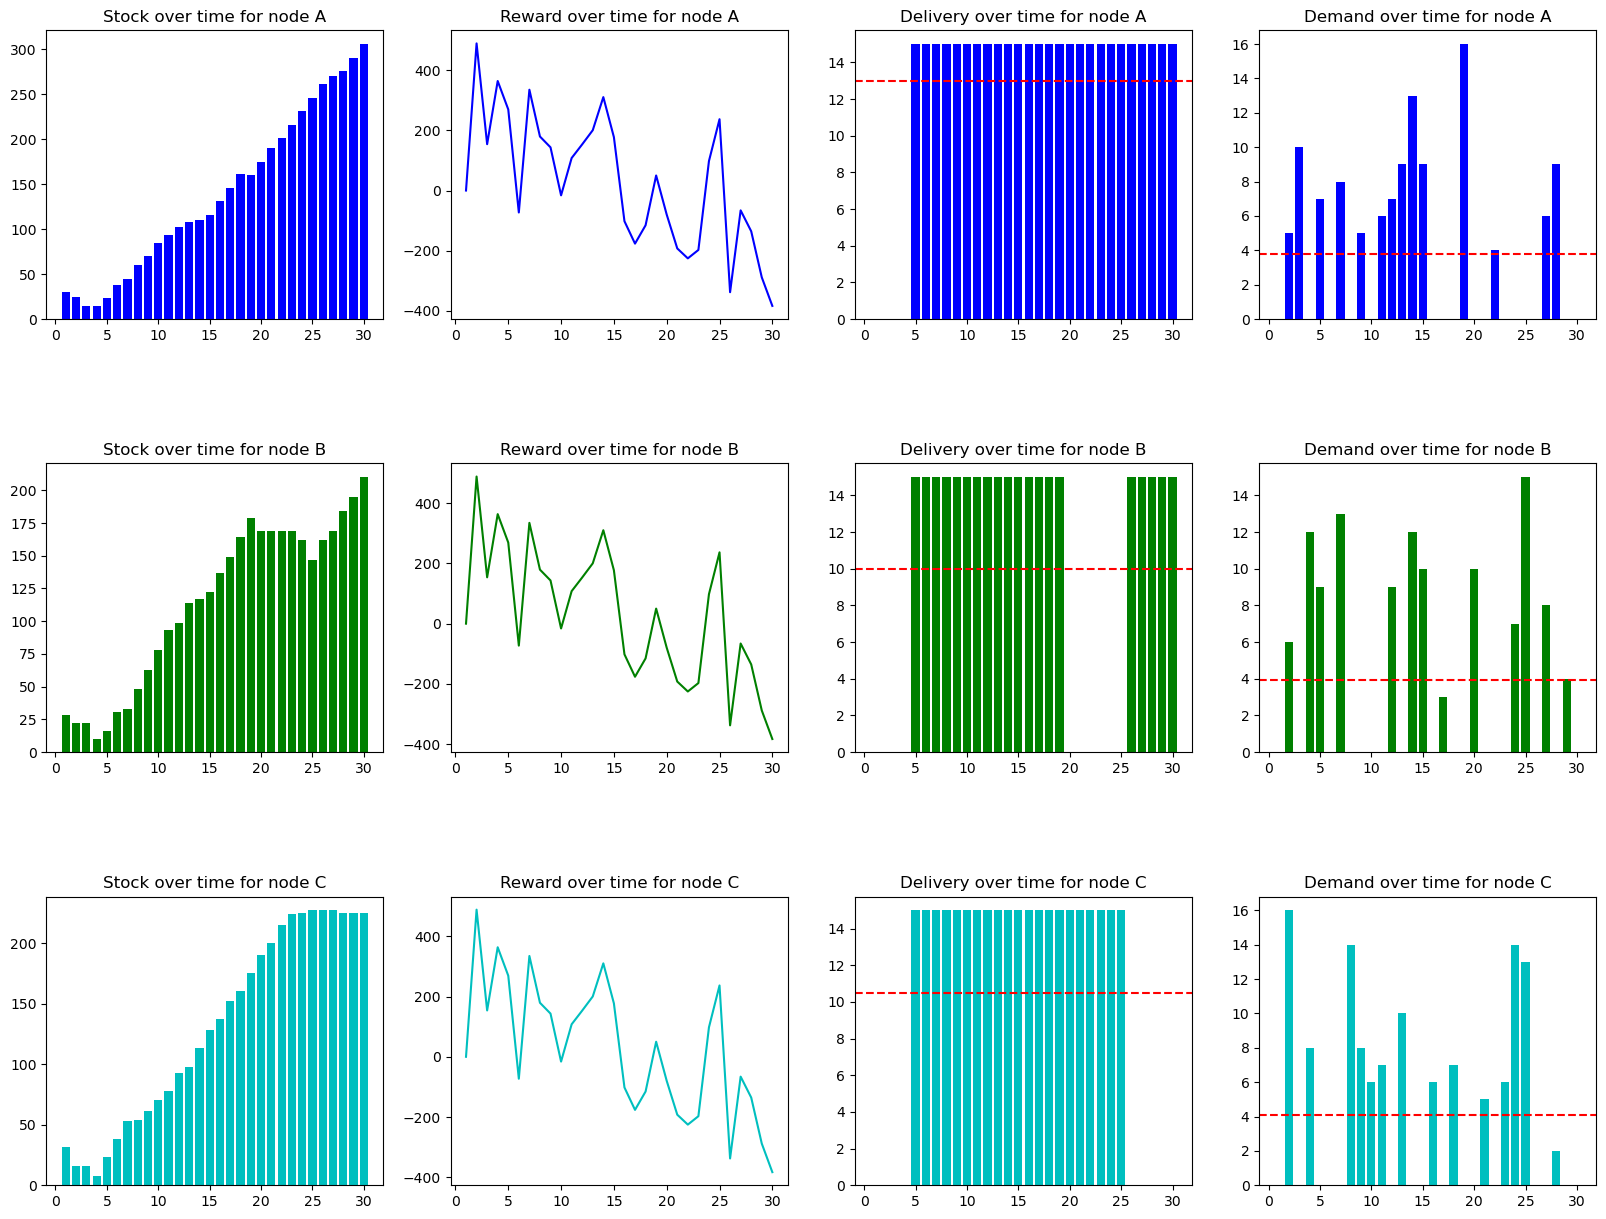

In [21]:
plot_data(df)